In [1]:
import pandas as pd
import numpy as np
import torch.multiprocessing as mp
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from LEN_Scorer import Scorer
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.interpolate import interp1d
from Categorization import Categorizer
import torch
import copy
from torch.nn.functional import one_hot
# import os, sys; sys.path.append(os.path.dirname(os.path.realpath("LEN_Test/pytorch_explain/experiments/elens/")))
from load_datasets import load_mimic


In [2]:
mimicDF = pd.read_csv("../LEN_Test/data/TimeSeries.csv")
# targetDF = mimicDF['Mortality14Days']
# mimicDF = mimicDF.drop(['Mortality14Days'], axis=1)
mimicDF

,PatientID,Mortality14Days,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
0,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47083,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47084,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47085,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47086,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
mimicDF.describe()

,PatientID,Mortality14Days,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
count,47088.000000,47088.000000,484.000000,481.000000,705.000000,245.000000,31415.000000,31503.000000,31504.000000,8601.000000,...,12981.000000,14768.000000,14714.000000,4352.000000,2485.000000,32961.000000,85.000000,26516.000000,331.000000,2118.000000
mean,151079.910805,0.039755,630.123967,954.301455,67.382553,2.721633,77.058157,57.226709,117.544502,40.565399,...,33.217492,987.290546,1917.421073,96.799012,138.022942,97.267665,64.988235,37.235334,2.529305,12.747691
std,29378.613191,0.195386,1245.805613,2384.326867,5.448469,0.584693,14.324177,11.197415,21.311674,7.078312,...,10.474703,363.504762,608.801780,2.659592,5.435978,3.083466,10.518118,1.399548,3.004787,5.523420
min,100059.000000,0.000000,3.000000,3.000000,48.000000,1.400000,0.000000,0.000000,0.000000,15.000000,...,0.000000,0.000000,0.000000,42.000000,1.210000,0.000000,43.000000,0.000000,0.000000,1.900000
25%,126241.000000,0.000000,25.000000,49.000000,64.000000,2.400000,68.000000,50.000000,103.000000,36.000000,...,26.168200,737.500000,1494.877533,96.000000,136.000000,96.000000,58.000000,36.900002,0.600000,9.000000
50%,151857.000000,0.000000,97.000000,137.000000,68.000000,2.700000,75.000000,56.000000,115.000000,40.000000,...,31.460699,931.028503,1841.049988,97.000000,138.000000,98.000000,65.000000,37.299999,1.400000,11.900000
75%,176484.000000,0.000000,554.750000,797.000000,70.000000,3.000000,84.000000,63.000000,129.000000,44.000000,...,38.118801,1169.229980,2244.340088,98.000000,140.000000,100.000000,71.000000,37.700001,3.300000,15.500000
max,199998.000000,1.000000,8100.000000,23060.000000,160.000000,4.400000,287.000000,191.000000,255.000000,91.000000,...,179.212997,3784.620117,6000.000000,100.000000,164.000000,100.000000,100.000000,46.500000,16.400000,48.300000


In [4]:
print(f"There are {mimicDF['PatientID'].nunique()} unique patients in the dataset")

There are 1126 unique patients in the dataset


In [5]:
# class Reading:

#     def __init__(self, time, readingData):
#         self.time = time
#         self.readingData = readingData

#     def __repr__(self):
#         return f"Time_index: {self.time}\n Data: {self.readingData}"

In [6]:
class Patient:

    def __init__(self, patientID, data):
        self.patientID = patientID
        self.data = data


    def __repr__(self):
        return f"PatientID: {self.patientID}\n Readings: {self.data}"
    

In [7]:
for id in mimicDF['PatientID'].unique()[:1]:
    patientDF = mimicDF[mimicDF['PatientID'] == id]
    display(patientDF)

,PatientID,Mortality14Days,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
0,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
patients = []

for id in mimicDF['PatientID'].unique():
    patientDF = mimicDF[mimicDF['PatientID'] == id].reset_index().drop(columns=['PatientID', 'index'])
    patient = Patient(id, patientDF)
    patients.append(patient)

print(len(patients))

1126


In [9]:
print(patients[1].data)

    Mortality14Days  ALT  AST  Admit Ht  Albumin  Arterial BP Mean  \
0                 0  NaN  NaN       NaN      NaN              84.0   
1                 0  NaN  NaN       NaN      NaN              85.0   
2                 0  NaN  NaN       NaN      NaN              84.0   
3                 0  NaN  NaN       NaN      NaN              91.0   
4                 0  NaN  NaN       NaN      NaN              68.0   
5                 0  NaN  NaN       NaN      NaN              82.0   
6                 0  NaN  NaN      68.0      NaN               NaN   
7                 0  NaN  NaN       NaN      NaN              72.0   
8                 0  NaN  NaN       NaN      NaN              68.0   
9                 0  NaN  NaN       NaN      NaN              71.0   
10                0  NaN  NaN       NaN      NaN              70.0   
11                0  NaN  NaN       NaN      NaN              84.0   
12                0  NaN  NaN       NaN      NaN              85.0   
13                0 

In [10]:
cleaningDF = patients[1].data
cleaningDF.head()

,Mortality14Days,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,Arterial PaO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
0,0,NaN,NaN,NaN,NaN,84.0,46.0,116.0,NaN,NaN,...,21.844700,1094.020020,2255.510010,NaN,NaN,97.0,NaN,37.200001,NaN,NaN
1,0,NaN,NaN,NaN,NaN,85.0,60.0,129.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,99.0,NaN,37.200001,NaN,NaN
2,0,NaN,NaN,NaN,NaN,84.0,54.0,117.0,42.0,90.0,...,NaN,NaN,NaN,NaN,NaN,99.0,NaN,37.099998,NaN,NaN
3,0,NaN,NaN,NaN,NaN,91.0,55.0,125.0,NaN,NaN,...,25.242701,1146.900024,2364.959961,NaN,NaN,93.0,NaN,37.000000,NaN,NaN
4,0,NaN,NaN,NaN,NaN,68.0,43.0,96.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,93.0,NaN,36.799999,NaN,NaN


In [11]:
columnsToInterpolate = ['Glucose']

noInterpolation = 0

interpolatedPatients = patients.copy()

for patient in interpolatedPatients:
    try:
        patient.data[columnsToInterpolate] = patient.data[columnsToInterpolate].apply(lambda x: x.interpolate(method='polynomial', order=2))
    except ValueError:
        noInterpolation += 1
        continue

print(f"{noInterpolation}/{len(patients)} patients have no missing values")

65/1126 patients have no missing values


In [12]:
cleaningDF = patients[3].data[columnsToInterpolate]
cleaningDF.head()

,Glucose
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


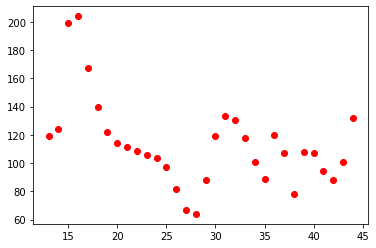

In [13]:
glucoseSeries = cleaningDF['Glucose']

generated = glucoseSeries.interpolate(method='polynomial', order=2)

# print(generated)
# for idx, value in enumerate(generated):
#     if str(glucoseSeries.iloc[idx]) != 'nan':
#         generated.iloc[idx]  = np.NaN

# print(generated)

plt.scatter(generated.index, generated, c='r')
# plt.scatter(glucoseSeries.index, glucoseSeries)

plt.show()

In [14]:
display(patients[3].data['Mortality14Days'].max())

0

In [15]:
pd.set_option('display.max_rows', 1000)

In [16]:
# Aggregating the dataset

staticPatients = []

target = []

for patient in patients:

    curr = {}

    df = patient.data

    # curr['PatientID'] = patient.patientID
    target.append(df['Mortality14Days'].max())
    curr['ALT'] = df['ALT'].max()
    curr['AST'] = df['AST'].max()
    curr['Admit Ht'] = df['Admit Ht'].max()
    curr['Albumin'] = df['Albumin'].min()
    curr['Arterial BP Mean'] = df['Arterial BP Mean'].min()
    curr['Arterial BP [Diastolic]'] = df['Arterial BP [Diastolic]'].min()
    curr['Arterial BP [Systolic]'] = df['Arterial BP [Systolic]'].min()
    curr['Arterial PaCO2'] = df['Arterial PaCO2'].min()
    curr['Arterial PaO2'] = df['Arterial PaO2'].min()
    curr['Arterial pH Max'] = df['Arterial pH'].max()
    curr['Arterial pH Min'] = df['Arterial pH'].min()
    curr['Urea'] = df['BUN'].min() * 0.357
    curr['CVP Min'] = df['CVP'].min()
    curr['CVP Max'] = df['CVP'].max()
    curr['CaO2'] = df['CaO2'].min()
    curr['Chloride'] = df['Chloride'].min()
    curr['Creatinine'] = df['Creatinine'].min()
    curr['Daily Weight'] = df['Daily Weight'].loc[df['Daily Weight'].first_valid_index()] / 2.205 if df['Daily Weight'].first_valid_index() is not None else None
    curr['Fibrinogen'] = df['Fibrinogen'].max()
    curr['Glucose Max'] = df['Glucose'].max()
    curr['Glucose Min'] = df['Glucose'].min()
    curr['Heart Rate Min'] = df['Heart Rate'].min()
    curr['Heart Rate Max'] = df['Heart Rate'].max()
    curr['Hamoglobin'] = df['Hemoglobin'].min()
    curr['INR'] = df['INR'].max()
    curr['Ionized Calcium'] = df['Ionized Calcium'].min()
    curr['LDH'] = df['LDH'].max()
    curr['Magnesium'] = df['Magnesium'].min()
    curr['NBP Mean'] = df['NBP Mean'].min()
    curr['NBP [Diastolic]'] = df['NBP [Diastolic]'].min()
    curr['NBP [Systolic]'] = df['NBP [Systolic]'].min()
    curr['PTT'] = df['PTT'].max()
    curr['Platelets'] = df['Platelets'].min()
    curr['Potassium Max'] = df['Potassium'].max()
    curr['Potassium Min'] = df['Potassium'].min()
    curr['Resp Rate (Spont) Min'] = df['Resp Rate (Spont)'].min()
    curr['Resp Rate (Spont) Max'] = df['Resp Rate (Spont)'].max()
    curr['SVI'] = df['SVI'].min()
    curr['SVRI Max'] = df['SVRI'].max()
    curr['SVRI Min'] = df['SVRI'].min()
    curr['SaO2'] = df['SaO2'].min()
    curr['Sodium Max'] = df['Sodium'].max()
    curr['Sodium Min'] = df['Sodium'].min()
    curr['SpO2'] = df['SpO2'].min()
    curr['SvO2 Max'] = df['SvO2'].max()
    curr['SvO2 Min'] = df['SvO2'].min()
    curr['Temperature C Max'] = df['Temperature C'].max()
    curr['Temperature C Min'] = df['Temperature C'].min()
    curr['Bilirubin'] = df['Total Bili'].max()
    curr['White Blood Cells Max'] = df['WBC'].max()
    curr['White Blood Cells Min'] = df['WBC'].min()

    staticPatients.append(curr)


staticPatientsDF = pd.DataFrame([x.values() for x in staticPatients], columns=curr.keys())

targetSeries = pd.Series(data=target)

display(targetSeries)

display(staticPatientsDF)

0       0
1       0
2       0
3       0
4       0
       ..
1121    0
1122    0
1123    0
1124    0
1125    0
Length: 1126, dtype: int64

,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,Arterial PaO2,Arterial pH Max,...,Sodium Max,Sodium Min,SpO2,SvO2 Max,SvO2 Min,Temperature C Max,Temperature C Min,Bilirubin,White Blood Cells Max,White Blood Cells Min
0,NaN,NaN,65.0,NaN,64.0,48.0,99.0,39.0,80.0,7.50,...,138.0,133.0,90.0,NaN,NaN,38.799999,35.700001,NaN,12.1,8.2
1,NaN,NaN,68.0,NaN,68.0,42.0,96.0,42.0,83.0,7.48,...,NaN,NaN,92.0,NaN,NaN,38.200001,36.799999,NaN,NaN,NaN
2,NaN,NaN,64.0,NaN,63.0,46.0,86.0,37.0,84.0,7.40,...,136.0,134.0,93.0,NaN,NaN,37.700001,36.500000,NaN,13.3,11.3
3,NaN,NaN,70.0,NaN,57.0,46.0,77.0,31.0,65.0,7.46,...,137.0,131.0,93.0,NaN,NaN,38.299999,36.000000,NaN,12.6,12.6
4,NaN,NaN,NaN,NaN,60.0,43.0,95.0,45.0,93.0,7.35,...,142.0,141.0,82.0,NaN,NaN,38.099998,37.200001,NaN,17.4,13.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,NaN,NaN,NaN,NaN,54.0,36.0,88.0,37.0,82.0,7.41,...,NaN,NaN,93.0,NaN,NaN,38.500000,37.099998,NaN,NaN,NaN
1122,NaN,NaN,62.0,NaN,48.0,40.0,78.0,30.0,105.0,7.39,...,137.0,133.0,68.0,NaN,NaN,37.200001,36.099998,NaN,21.3,17.6
1123,NaN,NaN,62.0,NaN,64.0,50.0,77.0,32.0,56.0,7.40,...,145.0,142.0,91.0,NaN,NaN,39.700001,36.500000,NaN,13.7,11.1
1124,11.0,48.0,NaN,NaN,55.0,42.0,80.0,35.0,61.0,7.50,...,140.0,140.0,93.0,NaN,NaN,38.099998,37.599998,4.1,9.9,9.9


In [17]:
staticPatientsDF.describe()

,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,Arterial PaO2,Arterial pH Max,...,Sodium Max,Sodium Min,SpO2,SvO2 Max,SvO2 Min,Temperature C Max,Temperature C Min,Bilirubin,White Blood Cells Max,White Blood Cells Min
count,253.000000,250.000000,663.000000,143.000000,1096.000000,1097.000000,1097.000000,1075.000000,1075.000000,1083.000000,...,742.000000,742.000000,1126.00000,49.000000,49.000000,1126.000000,1126.000000,171.000000,731.000000,731.000000
mean,388.296443,652.108000,67.376471,2.613287,60.073905,43.779398,87.995442,34.494884,90.542763,7.607101,...,139.758760,136.113221,91.58659,68.367347,66.040816,37.029165,35.332380,2.094737,14.690014,11.269494
std,1014.823729,2053.610608,5.529188,0.584451,9.878763,11.453517,21.175211,5.266344,34.024617,5.456490,...,3.570727,7.843155,8.97472,11.305776,11.193300,5.621109,5.680826,2.696976,6.032519,4.910463
min,3.000000,3.000000,48.000000,1.400000,0.000000,0.000000,0.000000,15.000000,7.470000,7.230000,...,127.000000,1.210000,0.00000,45.000000,43.000000,0.000000,0.000000,0.100000,2.400000,1.900000
25%,19.000000,40.000000,64.000000,2.200000,55.000000,40.000000,82.000000,31.000000,70.000000,7.410000,...,138.000000,134.000000,91.00000,60.000000,57.000000,37.500000,35.700001,0.600000,10.600000,7.800000
50%,40.000000,79.500000,68.000000,2.600000,60.000000,45.000000,90.000000,35.000000,82.000000,7.440000,...,140.000000,136.000000,93.00000,69.000000,67.000000,37.900002,36.299999,1.000000,13.600000,10.600000
75%,220.000000,359.000000,70.000000,3.000000,65.000000,50.000000,98.000000,38.000000,102.500000,7.470000,...,142.000000,139.000000,95.00000,74.000000,74.000000,38.299999,36.900002,2.400000,17.550000,13.850000
max,8100.000000,23060.000000,160.000000,4.400000,106.000000,77.000000,170.000000,66.000000,389.000000,187.000000,...,164.000000,152.000000,100.00000,100.000000,98.000000,46.500000,38.900002,16.400000,48.300000,48.300000


In [18]:
colsWithNa = staticPatientsDF.isnull().any()

colsWithNa.where(colsWithNa == True).dropna()

ALT                        True
AST                        True
Admit Ht                   True
Albumin                    True
Arterial BP Mean           True
Arterial BP [Diastolic]    True
Arterial BP [Systolic]     True
Arterial PaCO2             True
Arterial PaO2              True
Arterial pH Max            True
Arterial pH Min            True
Urea                       True
CVP Min                    True
CVP Max                    True
CaO2                       True
Chloride                   True
Creatinine                 True
Daily Weight               True
Fibrinogen                 True
Glucose Max                True
Glucose Min                True
Hamoglobin                 True
INR                        True
Ionized Calcium            True
LDH                        True
Magnesium                  True
NBP Mean                   True
NBP [Diastolic]            True
NBP [Systolic]             True
PTT                        True
Platelets                  True
Potassiu

In [19]:
staticPatientsDF.isna().sum()

ALT                         873
AST                         876
Admit Ht                    463
Albumin                     983
Arterial BP Mean             30
Arterial BP [Diastolic]      29
Arterial BP [Systolic]       29
Arterial PaCO2               51
Arterial PaO2                51
Arterial pH Max              43
Arterial pH Min              43
Urea                        388
CVP Min                      36
CVP Max                      36
CaO2                        313
Chloride                    389
Creatinine                  388
Daily Weight                408
Fibrinogen                  795
Glucose Max                 382
Glucose Min                 382
Heart Rate Min                0
Heart Rate Max                0
Hamoglobin                   45
INR                         442
Ionized Calcium              73
LDH                         991
Magnesium                   445
NBP Mean                    519
NBP [Diastolic]             516
NBP [Systolic]              501
PTT     

In [20]:
# Doing Arterial BP Mean

# Create Pytorch model

X_train = staticPatientsDF[~staticPatientsDF['Arterial BP Mean'].isnull()]

X_train


,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,Arterial PaO2,Arterial pH Max,...,Sodium Max,Sodium Min,SpO2,SvO2 Max,SvO2 Min,Temperature C Max,Temperature C Min,Bilirubin,White Blood Cells Max,White Blood Cells Min
0,NaN,NaN,65.0,NaN,64.0,48.0,99.0,39.0,80.0,7.50,...,138.0,133.0,90.0,NaN,NaN,38.799999,35.700001,NaN,12.1,8.2
1,NaN,NaN,68.0,NaN,68.0,42.0,96.0,42.0,83.0,7.48,...,NaN,NaN,92.0,NaN,NaN,38.200001,36.799999,NaN,NaN,NaN
2,NaN,NaN,64.0,NaN,63.0,46.0,86.0,37.0,84.0,7.40,...,136.0,134.0,93.0,NaN,NaN,37.700001,36.500000,NaN,13.3,11.3
3,NaN,NaN,70.0,NaN,57.0,46.0,77.0,31.0,65.0,7.46,...,137.0,131.0,93.0,NaN,NaN,38.299999,36.000000,NaN,12.6,12.6
4,NaN,NaN,NaN,NaN,60.0,43.0,95.0,45.0,93.0,7.35,...,142.0,141.0,82.0,NaN,NaN,38.099998,37.200001,NaN,17.4,13.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,NaN,NaN,NaN,NaN,54.0,36.0,88.0,37.0,82.0,7.41,...,NaN,NaN,93.0,NaN,NaN,38.500000,37.099998,NaN,NaN,NaN
1122,NaN,NaN,62.0,NaN,48.0,40.0,78.0,30.0,105.0,7.39,...,137.0,133.0,68.0,NaN,NaN,37.200001,36.099998,NaN,21.3,17.6
1123,NaN,NaN,62.0,NaN,64.0,50.0,77.0,32.0,56.0,7.40,...,145.0,142.0,91.0,NaN,NaN,39.700001,36.500000,NaN,13.7,11.1
1124,11.0,48.0,NaN,NaN,55.0,42.0,80.0,35.0,61.0,7.50,...,140.0,140.0,93.0,NaN,NaN,38.099998,37.599998,4.1,9.9,9.9


In [21]:
fillNaModeDF = staticPatientsDF.copy()

for col in fillNaModeDF:
    # print(staticPatientsDF[col].value_counts())
    fillNaModeDF[col] = fillNaModeDF[col].fillna(fillNaModeDF[col].mode()[0])

display(fillNaModeDF)

,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,Arterial PaO2,Arterial pH Max,...,Sodium Max,Sodium Min,SpO2,SvO2 Max,SvO2 Min,Temperature C Max,Temperature C Min,Bilirubin,White Blood Cells Max,White Blood Cells Min
0,11.0,29.0,65.0,2.6,64.0,48.0,99.0,39.0,80.0,7.50,...,138.0,133.0,90.0,71.0,53.0,38.799999,35.700001,0.4,12.1,8.2
1,11.0,29.0,68.0,2.6,68.0,42.0,96.0,42.0,83.0,7.48,...,141.0,137.0,92.0,71.0,53.0,38.200001,36.799999,0.4,13.3,8.0
2,11.0,29.0,64.0,2.6,63.0,46.0,86.0,37.0,84.0,7.40,...,136.0,134.0,93.0,71.0,53.0,37.700001,36.500000,0.4,13.3,11.3
3,11.0,29.0,70.0,2.6,57.0,46.0,77.0,31.0,65.0,7.46,...,137.0,131.0,93.0,71.0,53.0,38.299999,36.000000,0.4,12.6,12.6
4,11.0,29.0,70.0,2.6,60.0,43.0,95.0,45.0,93.0,7.35,...,142.0,141.0,82.0,71.0,53.0,38.099998,37.200001,0.4,17.4,13.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,11.0,29.0,70.0,2.6,54.0,36.0,88.0,37.0,82.0,7.41,...,141.0,137.0,93.0,71.0,53.0,38.500000,37.099998,0.4,13.3,8.0
1122,11.0,29.0,62.0,2.6,48.0,40.0,78.0,30.0,105.0,7.39,...,137.0,133.0,68.0,71.0,53.0,37.200001,36.099998,0.4,21.3,17.6
1123,11.0,29.0,62.0,2.6,64.0,50.0,77.0,32.0,56.0,7.40,...,145.0,142.0,91.0,71.0,53.0,39.700001,36.500000,0.4,13.7,11.1
1124,11.0,48.0,70.0,2.6,55.0,42.0,80.0,35.0,61.0,7.50,...,140.0,140.0,93.0,71.0,53.0,38.099998,37.599998,4.1,9.9,9.9


In [22]:
display(fillNaModeDF.drop_duplicates())

,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,Arterial PaO2,Arterial pH Max,...,Sodium Max,Sodium Min,SpO2,SvO2 Max,SvO2 Min,Temperature C Max,Temperature C Min,Bilirubin,White Blood Cells Max,White Blood Cells Min
0,11.0,29.0,65.0,2.6,64.0,48.0,99.0,39.0,80.0,7.50,...,138.0,133.0,90.0,71.0,53.0,38.799999,35.700001,0.4,12.1,8.2
1,11.0,29.0,68.0,2.6,68.0,42.0,96.0,42.0,83.0,7.48,...,141.0,137.0,92.0,71.0,53.0,38.200001,36.799999,0.4,13.3,8.0
2,11.0,29.0,64.0,2.6,63.0,46.0,86.0,37.0,84.0,7.40,...,136.0,134.0,93.0,71.0,53.0,37.700001,36.500000,0.4,13.3,11.3
3,11.0,29.0,70.0,2.6,57.0,46.0,77.0,31.0,65.0,7.46,...,137.0,131.0,93.0,71.0,53.0,38.299999,36.000000,0.4,12.6,12.6
4,11.0,29.0,70.0,2.6,60.0,43.0,95.0,45.0,93.0,7.35,...,142.0,141.0,82.0,71.0,53.0,38.099998,37.200001,0.4,17.4,13.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,11.0,29.0,70.0,2.6,54.0,36.0,88.0,37.0,82.0,7.41,...,141.0,137.0,93.0,71.0,53.0,38.500000,37.099998,0.4,13.3,8.0
1122,11.0,29.0,62.0,2.6,48.0,40.0,78.0,30.0,105.0,7.39,...,137.0,133.0,68.0,71.0,53.0,37.200001,36.099998,0.4,21.3,17.6
1123,11.0,29.0,62.0,2.6,64.0,50.0,77.0,32.0,56.0,7.40,...,145.0,142.0,91.0,71.0,53.0,39.700001,36.500000,0.4,13.7,11.1
1124,11.0,48.0,70.0,2.6,55.0,42.0,80.0,35.0,61.0,7.50,...,140.0,140.0,93.0,71.0,53.0,38.099998,37.599998,4.1,9.9,9.9


In [23]:
cat = Categorizer(fillNaModeDF)

# cat.kBins(bins = 5)
cat.agglomerative(n_clusters = 5)
# cat.kMeans(n_clusters = 5)

# cat.display(num=3)

,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,Arterial PaO2,Arterial pH Max,...,Sodium Max,Sodium Min,SpO2,SvO2 Max,SvO2 Min,Temperature C Max,Temperature C Min,Bilirubin,White Blood Cells Max,White Blood Cells Min
0,0,0,1,1,2,2,3,3,1,3,...,1,2,3,2,0,3,3,0,1,0
1,0,0,2,1,3,1,2,3,1,3,...,2,3,3,2,0,3,4,0,1,0
2,0,0,0,1,2,2,2,2,1,1,...,1,2,3,2,0,2,4,0,1,1
3,0,0,2,1,1,2,1,1,0,2,...,1,1,3,2,0,3,3,0,1,2
4,0,0,2,1,2,1,2,4,1,0,...,2,4,2,2,0,2,4,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,0,0,2,1,1,1,2,2,1,1,...,2,3,3,2,0,3,4,0,1,0
1122,0,0,0,1,1,1,1,1,2,1,...,1,2,1,2,0,1,3,0,2,3
1123,0,0,0,1,2,2,1,1,0,1,...,3,4,3,2,0,3,4,0,1,1
1124,0,0,2,1,1,1,1,2,0,3,...,2,3,3,2,0,2,4,2,0,1


In [24]:
cat.categorizationTypes['agglomerative']

,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,Arterial PaO2,Arterial pH Max,...,Sodium Max,Sodium Min,SpO2,SvO2 Max,SvO2 Min,Temperature C Max,Temperature C Min,Bilirubin,White Blood Cells Max,White Blood Cells Min
0,0,0,1,1,2,2,3,3,1,3,...,1,2,3,2,0,3,3,0,1,0
1,0,0,2,1,3,1,2,3,1,3,...,2,3,3,2,0,3,4,0,1,0
2,0,0,0,1,2,2,2,2,1,1,...,1,2,3,2,0,2,4,0,1,1
3,0,0,2,1,1,2,1,1,0,2,...,1,1,3,2,0,3,3,0,1,2
4,0,0,2,1,2,1,2,4,1,0,...,2,4,2,2,0,2,4,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,0,0,2,1,1,1,2,2,1,1,...,2,3,3,2,0,3,4,0,1,0
1122,0,0,0,1,1,1,1,1,2,1,...,1,2,1,2,0,1,3,0,2,3
1123,0,0,0,1,2,2,1,1,0,1,...,3,4,3,2,0,3,4,0,1,1
1124,0,0,2,1,1,1,1,2,0,3,...,2,3,3,2,0,2,4,2,0,1


In [25]:
categories = {0: 'very_low', 1: 'low', 2: 'medium', 3: 'high', 4: 'very_high'}


cat.map_types(mapping=categories)

cat.mappedTypes['agglomerative']

,ALT_high,ALT_low,ALT_medium,ALT_very_high,ALT_very_low,AST_high,AST_low,AST_medium,AST_very_high,AST_very_low,...,White Blood Cells Max_high,White Blood Cells Max_low,White Blood Cells Max_medium,White Blood Cells Max_very_high,White Blood Cells Max_very_low,White Blood Cells Min_high,White Blood Cells Min_low,White Blood Cells Min_medium,White Blood Cells Min_very_high,White Blood Cells Min_very_low
0,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
2,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
1122,0,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
1123,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
1124,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0


In [26]:
targetSeries.value_counts()

0    1077
1      49
dtype: int64

In [27]:

for type in cat.mappedTypes:

    xTensor = torch.FloatTensor(cat.mappedTypes[type].to_numpy())
    yTensor = one_hot(torch.tensor(targetSeries).to(torch.long)).to(torch.float)

    scorer = Scorer(data=xTensor, target=yTensor, concept_names=cat.mappedTypes[type].columns)

    scorer.train()

    # scorer.explain(1)

Global seed set to 40
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Num concepts: 255
Num classes: 2
torch.Size([1126, 255])
tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]]) torch.Size([1126, 2])
Split [1/5]
720/180/226



  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | Sequential       | 10.3 K
-------------------------------------------
10.3 K    Trainable params
0         Non-trainable params
10.3 K    Total params
0.041     Total estimated model params size (MB)
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\benma\OneDrive\Kings\Modules\Term 2\Individual Project\LEN Individual Project\Static\results\mimicLEN\explainer exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Global seed set to 40
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 199: 100%|██████████| 3/3 [00:00<00:00, 57.70it/s, loss=0.101, v_num=39, train_loss_step=0.100, train_acc_step=0.968, val_loss_step=0.129, val_acc_step=0.955, val_loss_epoch=0.232, val_acc_epoch=0.944, train_loss_epoch=0.100, train_acc_epoch=0.968] 
Gamma: tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False,  True, False, False,  True, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False,  True, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, Fal

c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9469026327133179, 'test_acc_epoch': 0.9469026327133179}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:00<00:00, 142.86it/s]
Extracted concepts: 10
Extracted concepts: 11
Extracted concepts: 10
Explanation: CVP Min_very_low | ~SVRI Min_very_high
Explanation accuracy: 0.4851936218678816
Extracted concepts: 11
Explanation: None
Explanation accuracy: 0
tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False,  True, False, False,  True, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False,

In [28]:
# x, y, concept_names = load_mimic("../LEN_Test/pytorch_explain/experiments/elens/data")

# print(x)

['CVP Min_very_low | ~SVRI Min_very_high']


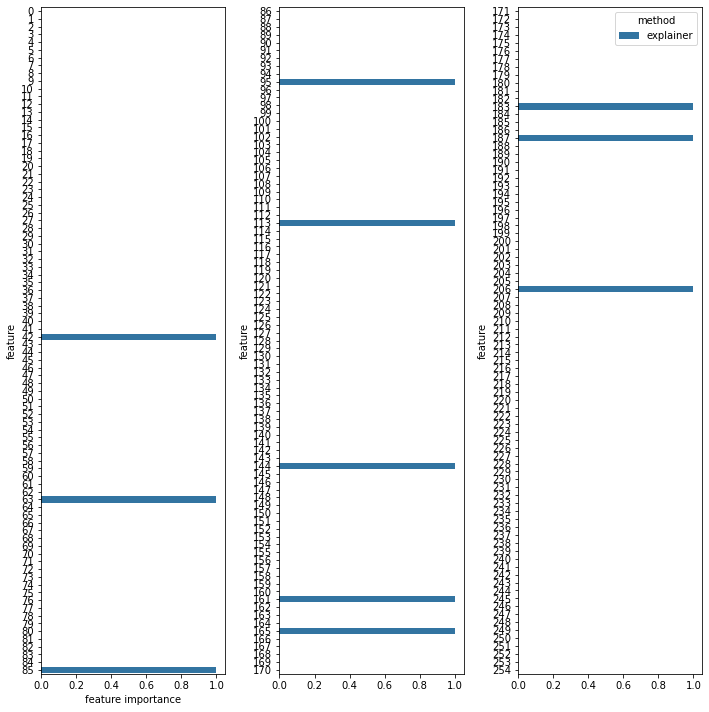

0      explainer
1      explainer
2      explainer
3      explainer
4      explainer
5      explainer
6      explainer
7      explainer
8      explainer
9      explainer
10     explainer
11     explainer
12     explainer
13     explainer
14     explainer
15     explainer
16     explainer
17     explainer
18     explainer
19     explainer
20     explainer
21     explainer
22     explainer
23     explainer
24     explainer
25     explainer
26     explainer
27     explainer
28     explainer
29     explainer
30     explainer
31     explainer
32     explainer
33     explainer
34     explainer
35     explainer
36     explainer
37     explainer
38     explainer
39     explainer
40     explainer
41     explainer
42     explainer
43     explainer
44     explainer
45     explainer
46     explainer
47     explainer
48     explainer
49     explainer
50     explainer
51     explainer
52     explainer
53     explainer
54     explainer
55     explainer
56     explainer
57     explainer
58     explain

In [29]:
scorer.explain()